# Prepare the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.model_selection import train_test_split

In [2]:
credits = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('/Users/xhan/OneDrive/dataset/tmdb-5000-movie-dataset/tmdb_5000_movies.csv')

In [3]:
movies_sub = movies.loc[:, ['id', 'original_title', 'genres']]
credits_sub = credits.loc[:, ['movie_id', 'cast']].rename(columns={'movie_id':'id'})
df = movies_sub.merge(credits_sub)

In [4]:
def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1: female += 1
        else: male += 1
            
    return female, male

In [5]:
def modify_df(cell):
    """Convert string-format json cell to list"""
    my_list = []
    for item in json.loads(cell):
        my_list.append(item['name'])
 
    return my_list

In [6]:
# drop movies with no cast/genre info
for i, row in df.iterrows():
    if row['cast'] == '[]' or row['genres'] == '[]':
        df.drop(i, inplace=True)
    #df1.at[i, 'cast_list'] = ' '.join(row['cast_list'])

In [7]:
df = df.dropna()
df.head(5)

,id,original_title,genres,cast
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [8]:
for col_name in ['genres', 'cast']:
    if col_name == 'cast':
        gen = df[col_name].apply(extract_gender)
        df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]))
        df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]))
    
    df[col_name] = df[col_name].apply(modify_df)

### Delete cast with less than three movies

In [9]:
# All cast: # of movies
cast_all = defaultdict(int)

for names in df.cast:
    for p in names:
        cast_all[p] += 1

sorted(cast_all.items(), key=lambda x: x[1], reverse=True)[:5]

[('Samuel L. Jackson', 67),
 ('Robert De Niro', 57),
 ('Bruce Willis', 51),
 ('Matt Damon', 48),
 ('Morgan Freeman', 46)]

In [10]:
# actors/actresses who have less than three movies
cast_remove = [key for (key, value) in cast_all.items() if value <= 2]

In [11]:
# drop cast who have too few movies
for i, row in df.iterrows():
    df.at[i, 'cast'] = list(set(row.cast) - set(cast_remove))
#     for j, name in enumerate(row.cast_list):
#         row['cast_list'][j] = name.replace(' ', '')

### Genres Overview

In [12]:
all_genres = defaultdict(int)

for row in df.genres:
    for item in row:
        all_genres[item] += 1

all_genres

defaultdict(int,
            {'Action': 1152,
             'Adventure': 790,
             'Fantasy': 424,
             'Science Fiction': 534,
             'Crime': 695,
             'Drama': 2293,
             'Thriller': 1272,
             'Animation': 234,
             'Family': 510,
             'Western': 82,
             'Comedy': 1719,
             'Romance': 893,
             'Horror': 519,
             'Mystery': 347,
             'History': 197,
             'War': 144,
             'Music': 184,
             'Documentary': 92,
             'Foreign': 33,
             'TV Movie': 8})

In [13]:
genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 2293),
 ('Comedy', 1719),
 ('Thriller', 1272),
 ('Action', 1152),
 ('Romance', 893),
 ('Adventure', 790),
 ('Crime', 695),
 ('Science Fiction', 534),
 ('Horror', 519),
 ('Family', 510),
 ('Fantasy', 424),
 ('Mystery', 347),
 ('Animation', 234),
 ('History', 197),
 ('Music', 184),
 ('War', 144),
 ('Documentary', 92),
 ('Western', 82),
 ('Foreign', 33),
 ('TV Movie', 8)]

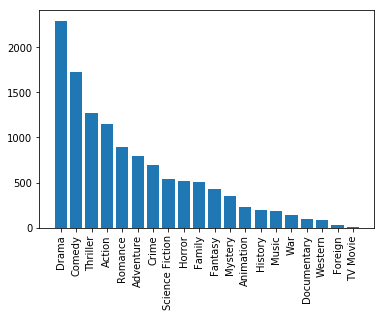

In [14]:
plt.bar(x = [x[0] for x in genres_list], height = [y[1] for y in genres_list])
plt.xticks(rotation=90)
plt.show()

## Pairwise analysis of Movie Genres


Put highly dependent labels into the same cluster, so that we can assume the four resulting clusters are approximately independent.


*Source: https://spandan-madan.github.io/DeepLearningProject/*

In [15]:
import itertools

# This function just generates all possible pairs of movies
def list2pairs(genres):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(genres, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for genre in genres:
        pairs.append([genre, genre])
    return pairs

In [16]:
# get all genre lists pairs from all movies
allPairs = []
for cell in df.genres:
    allPairs.extend(list2pairs(cell))
    
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

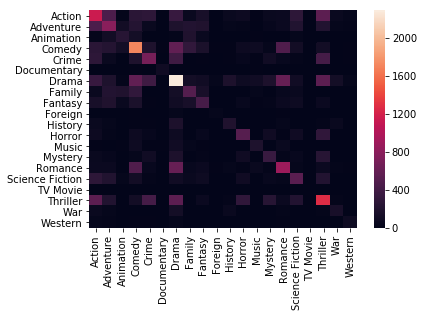

In [17]:
import seaborn as sns

# shows how often the genres occur together
annot_lookup = []
for i in range(len(nr_ids)):
    annot_lookup.append(nr_ids[i])

sns.heatmap(visGrid, xticklabels=annot_lookup, yticklabels=annot_lookup)

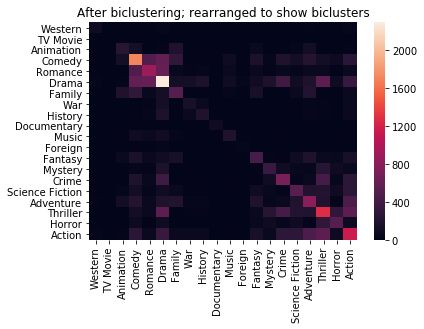

In [18]:
# co-cluster the genres
# n_clusters=4 has the best result
from sklearn.cluster import SpectralCoclustering

model = SpectralCoclustering(n_clusters=4, svd_method='arpack', random_state=0)
model.fit(visGrid)

fit_data = visGrid[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

annot_lookup_sorted = []
for i in np.argsort(model.row_labels_):
    annot_lookup_sorted.append(nr_ids[i])
    
sns.heatmap(fit_data, xticklabels=annot_lookup_sorted, yticklabels=annot_lookup_sorted, annot=False)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

**Four clusters:**  
+ **Exciting**: Thriller, Horror, Action, Adventure, Sci-Fi, Crime, Mystery, Fantasy    
+ **Uplifting**: Drama, Romance, Comedy, Family  
+ **Reality:** Documentary, War, History, Foreign, Music
+ **Others:** Western, TV Movie, Animation

## Change genres to four new subsets

In [19]:
new_genres = []

for i, cell in enumerate(df.genres):
    cell_genre = []
    for item in cell:
        if item in ['Thriller', 'Horror', 'Action', 'Adventure', 'Science Fiction', 'Crime', 'Mystery', 'Fantasy']:
            cell_genre.append('Exciting')
        elif item in ['Drama', 'Romance', 'Comedy', 'Family']:
            cell_genre.append('Uplifting')
        elif item in ['Documentary', 'War', 'History', 'Foreign', 'Music']:
            cell_genre.append('Reality')
        else:
            cell_genre.append('Others')
    new_genres.append(list(set(cell_genre)))

df['genres'] = new_genres

## Cast vs. Genres

In [20]:
for i, row in df.iterrows():
    df.at[i, 'cast'] = ' '.join(row['cast'])

In [21]:
df.head(5)

,id,original_title,genres,cast,female_pct,male_pct
0,19995,Avatar,[Exciting],Wes Studi Peter Mensah Matt Gerald Giovanni Ri...,0.144578,0.855422
1,285,Pirates of the Caribbean: At World's End,[Exciting],Chow Yun-fat Lauren Maher Mackenzie Crook Chri...,0.147059,0.852941
2,206647,Spectre,[Exciting],Ralph Fiennes Jesper Christensen Karl Farrer J...,0.156627,0.843373
3,49026,The Dark Knight Rises,"[Uplifting, Exciting]",Daniel Newman LeJon Matthew Modine William Dev...,0.069620,0.930380
4,49529,John Carter,[Exciting],Lynn Collins Bryan Cranston Dominic West Taylo...,0.222222,0.777778


### One-vs-Rest

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [23]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, hamming_loss
from sklearn.metrics import roc_auc_score

In [24]:
# One-Hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit_transform(df.genres)
train_data, test_data, train_labels, test_labels = train_test_split(df.iloc[:, 3], mlb.transform(df.genres),
                                                                    test_size=0.1, random_state=0)

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
train_cast_vect = vectorizer.fit_transform(train_data)
test_cast_vect = vectorizer.transform(test_data)

# train_features = np.concatenate((train_cast_vect.todense(), np.asmatrix(train_data.iloc[:, 1:])), axis=1)
# test_features = np.concatenate((test_cast_vect.todense(), np.asmatrix(test_data.iloc[:, 1:])), axis=1)

In [26]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

parameters = {'alpha':10**np.linspace(-1, 1, 10), 
              'fit_prior':[True, False]}
# gridCV = GridSearchCV(SVC(class_weight='balanced'), parameters, 
gridCV = GridSearchCV(MultinomialNB(), parameters, 
                      scoring=make_scorer(f1_score, average='micro'), cv=5)
clf = OneVsRestClassifier(gridCV)

clf.fit(train_cast_vect, train_labels)
y_score = clf.fit(train_cast_vect, train_labels).predict_proba(test_cast_vect)
predicted = clf.predict(test_cast_vect)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted, target_names=mlb.classes_))

              precision    recall  f1-score   support

    Exciting       0.71      0.84      0.77       279
      Others       0.71      0.12      0.21        40
     Reality       0.00      0.00      0.00        56
   Uplifting       0.78      0.98      0.87       352

   micro avg       0.75      0.80      0.78       727
   macro avg       0.55      0.49      0.46       727
weighted avg       0.69      0.80      0.73       727
 samples avg       0.77      0.85      0.77       727



/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [28]:
accuracy = accuracy_score(y_pred=predicted, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
precision = precision_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')
recall = recall_score(y_pred=predicted, y_true=np.array(test_labels), average='micro')

print("Accuracy: {}".format(accuracy)) # subset accuracy
print("F1 score: {}".format(f1))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Accuracy: 0.4231578947368421
F1 score: 0.7753479125248508
Precision: 0.7480818414322251
Recall: 0.8046767537826685


In [29]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

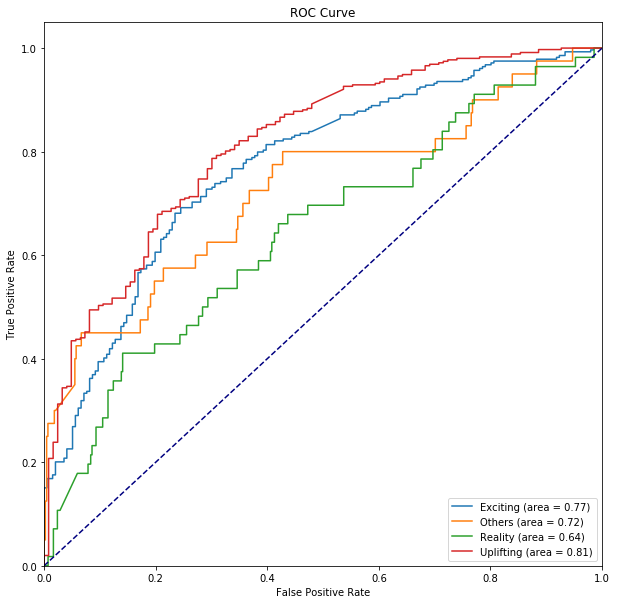

In [30]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(mlb.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
mlb.classes_

array(['Exciting', 'Others', 'Reality', 'Uplifting'], dtype=object)

In [32]:
# for d in zip(predicted, np.array(test_labels)):
#     print('Predicted:{}, ground truth:{}'.format(d[0], d[1]))

Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[1 0 0 1], ground truth:[0 0 0 1]
Predicted:[0 0 0 1], ground truth:[0 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[1 0 0 1], ground truth:[1 1 0 1]
Predicted:[0 0 0 1], ground truth:[0 0 0 1]
Predicted:[1 0 0 0], ground truth:[1 0 0 0]
Predicted:[1 0 0 1], ground truth:[1 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[0 0 0 1], ground truth:[0 0 0 1]
Predicted:[1 0 0 1], ground truth:[0 0 1 1]
Predicted:[1 0 0 1], ground truth:[0 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 1]
Predicted:[0 0 0 1], ground truth:[0 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[0 0 0 1], ground truth:[1 0 0 0]
Predicted:[1 0 0 1], ground truth:[1 0 1 1]
Predicted:[1 0 0 1], ground truth:[1 1 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 1]
Predicted:[1 0 0 1], ground truth:[1 0 0 0]
Predicted:[0 0 0 1], ground trut